(glossary:ellipse_fitting:code)=
# Ellipsoid fitting

Napari-stress implements several algorithms for ellipse fitting. They all have in common that they return a napari [vectors layer](https://napari.org/stable/howtos/layers/vectors.html) which represents the three major axes of the fitted ellipsoid. Napari-stress provides some further functionality to project the input pointcloud onto the surface of the fitted ellipsoid.

* [Napari-stress implementation](#napari-stress) Least squares ellipsoid fitting
* [Vedo implementation](#vedo) Statistical ellipsoid fitting
* [Quantification](#quality) Quantify fit quality
* [Mean curvature](#mean_curvature) Measure mean curvature on ellipsoid

In [1]:
import napari_stress
from napari_stress import approximation, measurements
import napari
import numpy as np

import matplotlib.pyplot as plt

## Napari-stress implementation <a class="anchor" id="napari-stress"></a>

This is a [least-squares](https://en.wikipedia.org/wiki/Least_squares) approach at ellipse fitting.

In [2]:
pointcloud = napari_stress.get_droplet_point_cloud()[0][0][:, 1:]
ellipsoid_stress = approximation.least_squares_ellipsoid(pointcloud)

Assistant skips harvesting pyclesperanto as it's not installed.


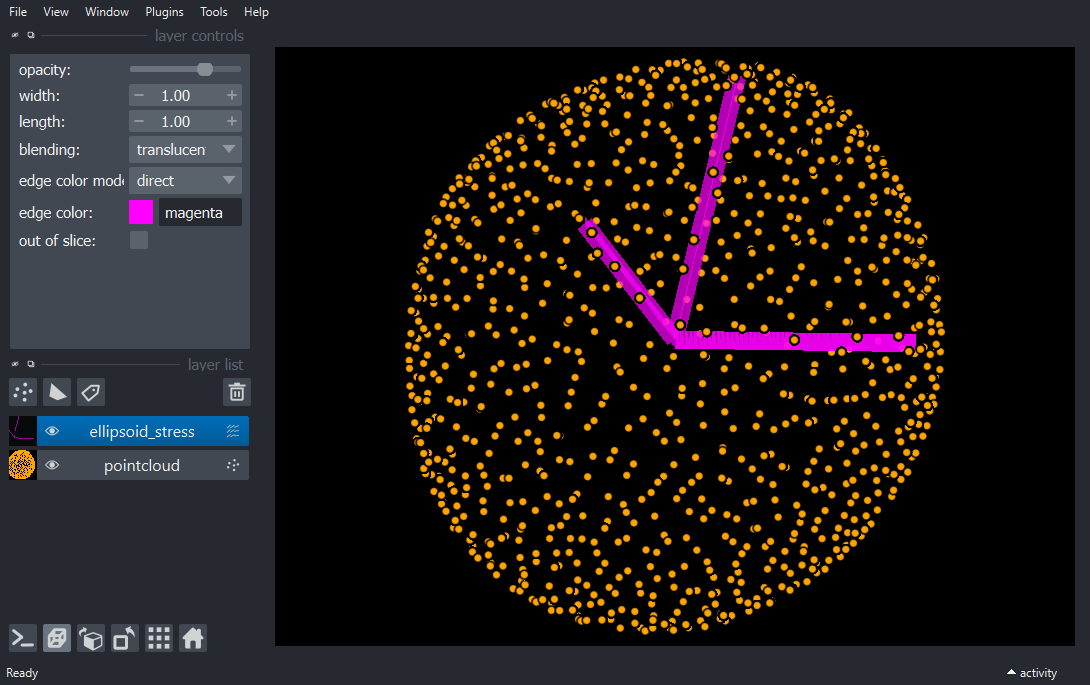

In [3]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_points(pointcloud, size=0.5, face_color='orange')
viewer.add_vectors(ellipsoid_stress, edge_width=1, edge_color='magenta')
napari.utils.nbscreenshot(viewer)

To display, where the initial input points would fall on the surface of the fitted ellipse, use the `expand_points_on_ellipse()` function:

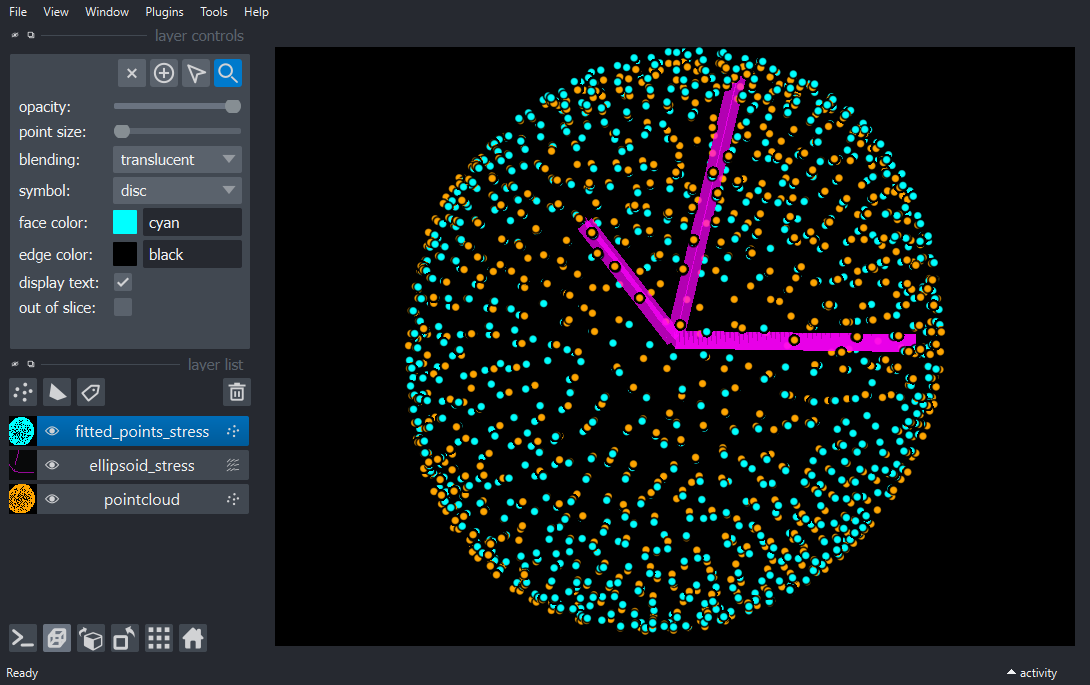

In [4]:
fitted_points_stress = approximation.expand_points_on_ellipse(ellipsoid_stress, pointcloud)
viewer.add_points(fitted_points_stress, size=0.5, face_color='cyan')
napari.utils.nbscreenshot(viewer)

## Vedo implementation <a class="anchor" id="vedo"></a>
This function re-implements the [respective function](https://vedo.embl.es/autodocs/content/vedo/pointcloud.html#vedo.pointcloud.pcaEllipsoid) from the vedo library. It applies a [PCA-algorithm](https://en.wikipedia.org/wiki/Principal_component_analysis) to a pointcloud to retrieve the major and minor axises of an ellipsoid, that comprises a set fraction of points within its volumne. The `inside_fraction` parameter controls how many points of the pointcloud will be located within the volume of the determined ellipsoid.

In [5]:
viewer2 = napari.Viewer(ndisplay=3)
viewer2.add_points(pointcloud, size=0.5, face_color='orange')

<Points layer 'pointcloud' at 0x1ac7385fe20>

In [6]:
ellipsoid_vedo = napari_stress.fit_ellipsoid_to_pointcloud_vectors(pointcloud, inside_fraction=0.675)
fitted_points_vedo = approximation.expand_points_on_ellipse(ellipsoid_vedo, pointcloud)

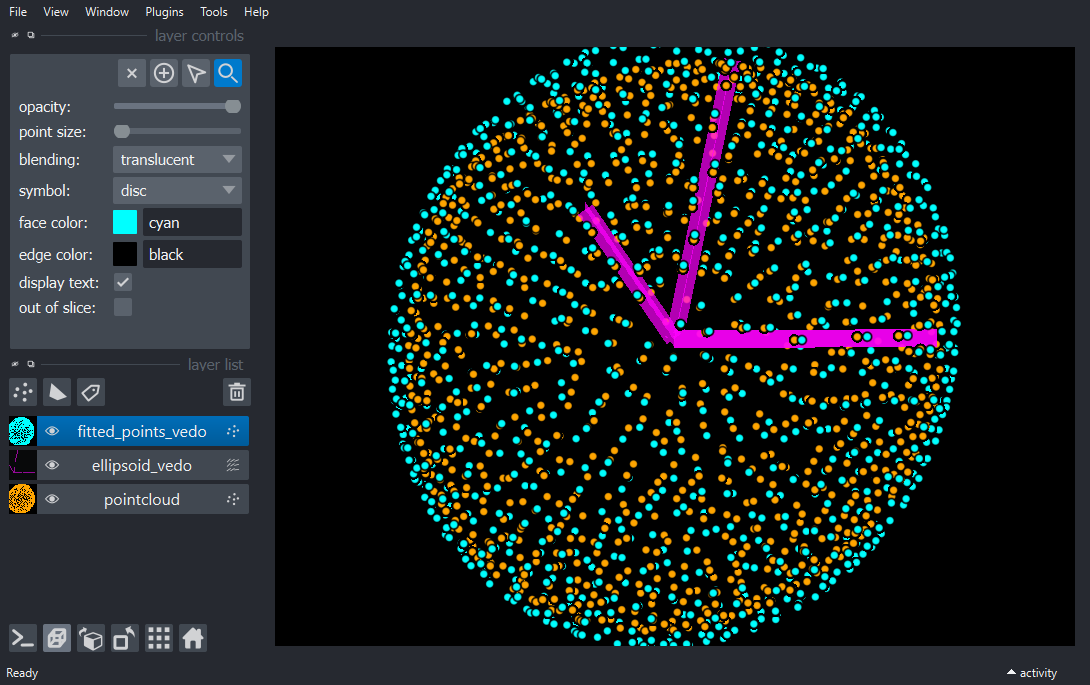

In [7]:
viewer2.add_vectors(ellipsoid_vedo, edge_width=1, edge_color='magenta')
viewer2.add_points(fitted_points_vedo, size=0.5, face_color='cyan')
napari.utils.nbscreenshot(viewer2)

## Fit quality quantification <a class="anchor" id="quality"></a>

Lastly, if you wanted to quantify the fit remainder (i.e., the distance between the input and the fitted points), you can do this with `approximation.pairwise_point_distances()`:

In [8]:
residues = approximation.pairwise_point_distances(pointcloud, fitted_points_stress)

You can calculate the length of these vectors using numpy:

In [9]:
lengths = np.linalg.norm(residues[:, 1], axis=1)

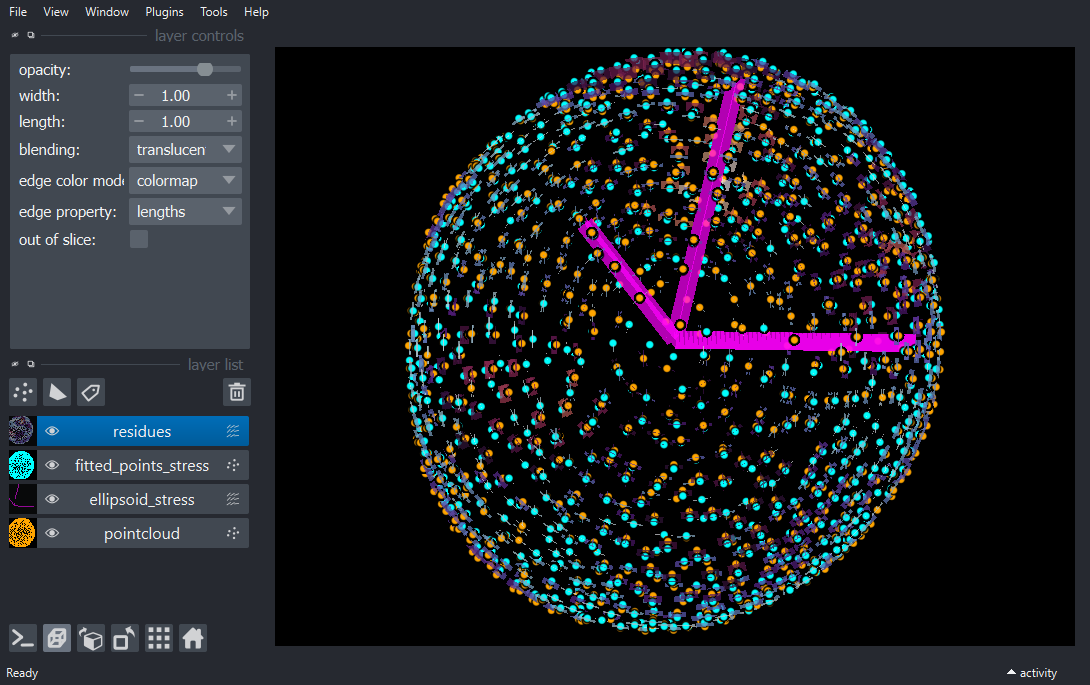

In [10]:
viewer.add_vectors(residues, edge_width=1, features = {'lengths': lengths}, edge_color = 'lengths', edge_colormap = 'twilight')
napari.utils.nbscreenshot(viewer)

## Mean curvature on ellipsoid <a class="anchor" id="mean_curvature"></a>

Lastly, the curvature on the surface of an ellipsoid can be calculated esily with `measurements.curvature_on_ellipsoid`. *Note*: The bject returned from this function is of type `LayerDataTuple`, the structure of which is explained in the docstring. Use `help(measurements.curvature_on_ellipsoid)` to show.

In [11]:
result = measurements.curvature_on_ellipsoid(ellipsoid_stress, fitted_points_stress)

You can print the global curvatures on the ellipsoid: $H_e$ (average mean curvature $H_{e, 0}$ and maximal/minimal mean curvatures $H_{e, M}$ and  $H_{e, N}$)

In [12]:
for key in result[1]['metadata'].keys():
    print(key, ': ', result[1]['metadata'][key])

H0_ellipsoid :  0.06632935563602613
H_ellipsoid_major_medial_minor :  [0.0821162352111996, 0.06563346684870562, 0.05525323952723134]


Plot a histogram of curvatures...

Text(0.5, 0, 'Mean curvature')

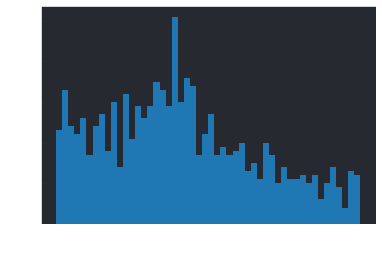

In [13]:
fig, ax = plt.subplots()
hist = ax.hist(result[1]['features']['mean_curvature'], 50)
ax.set_ylabel('Occurrences [#]')
ax.set_xlabel('Mean curvature')

...or visualize curvature in the napari viewer:

In [14]:
# make other layers invisble
for layer in viewer.layers:
    layer.visible = False

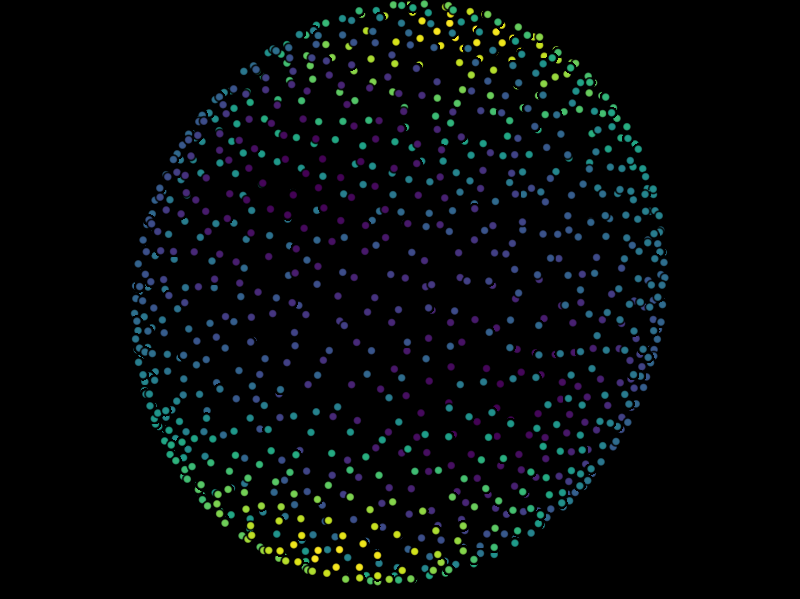

In [15]:
viewer.add_points(result[0], **result[1])
napari.utils.nbscreenshot(viewer, canvas_only=True)